Link to medium post: https://medium.com/@zhiwei_zhang/yelp-review-classification-b2816d990429

In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Embedding, Conv1D,MaxPooling1D, Flatten, Dense,Dropout,LSTM,Bidirectional
from keras.optimizers import RMSprop

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


### Load Data

In [2]:
data = pd.read_csv('review_star.csv')

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data = data.dropna()
text = data['text'].tolist()
binstars = data['stars'].tolist()
binstars = [int(star) for star in binstars]

### Make a balanced dataset of positive and negative review -- 50:50

In [4]:
balanced_texts = []   # contains 50000 positive reviews and 50000 negative reviews
balanced_labels = []     
count = 50000  
neg_pos = [0, 0]
for i in range(len(text)):
    sentiment = binstars[i]
    if neg_pos[sentiment] < count:
        balanced_texts.append(text[i])
        balanced_labels.append(binstars[i])
        neg_pos[sentiment] += 1

In [5]:
# cut reviews after 200 words
maxlen = 200 
# Number of words to consider as features
# restrict the yelp reviews to the top 10000 most common words
max_words = 10000  

training_samples = 75000  #  train on 75000 samples
test_samples = 25000  # test on 25000 samples

In [6]:
# create a tokenizer and it will ignore all except the 10000 most-common words
tokenizer = Tokenizer(num_words = max_words)
# use tokenizer to calculate the frequency of each word in dataset.
tokenizer.fit_on_texts(balanced_texts)
# convert all of reviews to lists of integers
sequences = tokenizer.texts_to_sequences(balanced_texts)
print(len(sequences[1]))
print(len(sequences[2]))


# use pad_sequence to make traning samples the same size, fill with zeros
data_input = pad_sequences(sequences, maxlen = maxlen)
labels = np.asarray(balanced_labels)

163
251


### train and test split

In [7]:
indices = np.arange(data_input.shape[0])
np.random.shuffle(indices)
data_input = data_input[indices]
labels = labels[indices]

# train on 75000，test on 25000
x_train = data_input[:training_samples]
y_train = labels[:training_samples]
x_test = data_input[training_samples: training_samples + test_samples]
y_test = labels[training_samples: training_samples + test_samples]
print(" x_train",x_train.shape)
print(" y_train",y_train.shape)


 x_train (75000, 200)
 y_train (75000,)


 ### Model 1 - Using Embedding layer and LSTM

In [9]:
max_words = 10000 
maxlen = 200
model = Sequential()
model.add(Embedding(max_words, 64,input_length = maxlen))
model.add(LSTM(64,dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 64)           640000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


In [81]:
history = model.fit(x_train, y_train,
                    epochs=5,
                    batch_size=128,
                    validation_split=0.2)

Train on 60000 samples, validate on 15000 samples
Epoch 1/5
60000/60000 [==============================] - 178s 3ms/step - loss: 0.4011 - acc: 0.8261 - val_loss: 0.3087 - val_acc: 0.8721
Epoch 2/5
60000/60000 [==============================] - 173s 3ms/step - loss: 0.3041 - acc: 0.8780 - val_loss: 0.3605 - val_acc: 0.8611
Epoch 3/5
60000/60000 [==============================] - 174s 3ms/step - loss: 0.2775 - acc: 0.8891 - val_loss: 0.2887 - val_acc: 0.8884
Epoch 4/5
60000/60000 [==============================] - 173s 3ms/step - loss: 0.2577 - acc: 0.8978 - val_loss: 0.2812 - val_acc: 0.8853
Epoch 5/5
60000/60000 [==============================] - 174s 3ms/step - loss: 0.2440 - acc: 0.9044 - val_loss: 0.3176 - val_acc: 0.8852


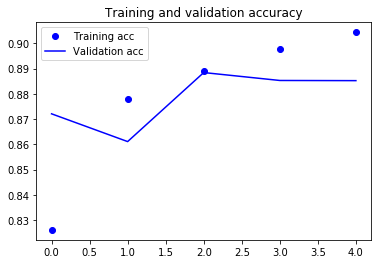

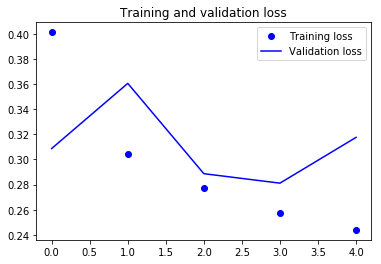

In [83]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [87]:
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 62s 2ms/step


[0.27423553356170655, 0.89592]

In [24]:
max_words = 10000 
maxlen = 200
model = Sequential()
model.add(Embedding(max_words, 64,input_length = maxlen))
model.add(LSTM(64,dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

In [25]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 60000 samples, validate on 15000 samples
Epoch 1/10
60000/60000 [==============================] - 176s 3ms/step - loss: 0.4057 - acc: 0.8234 - val_loss: 0.3069 - val_acc: 0.8730
Epoch 2/10
60000/60000 [==============================] - 172s 3ms/step - loss: 0.3034 - acc: 0.8780 - val_loss: 0.2875 - val_acc: 0.8842
Epoch 3/10
60000/60000 [==============================] - 173s 3ms/step - loss: 0.2740 - acc: 0.8910 - val_loss: 0.2831 - val_acc: 0.8867
Epoch 4/10
60000/60000 [==============================] - 170s 3ms/step - loss: 0.2549 - acc: 0.8994 - val_loss: 0.2820 - val_acc: 0.8874
Epoch 5/10
60000/60000 [==============================] - 167s 3ms/step - loss: 0.2439 - acc: 0.9032 - val_loss: 0.2809 - val_acc: 0.8848
Epoch 6/10
60000/60000 [==============================] - 167s 3ms/step - loss: 0.2355 - acc: 0.9068 - val_loss: 0.2842 - val_acc: 0.8867
Epoch 7/10
60000/60000 [==============================] - 166s 3ms/step - loss: 0.2255 - acc: 0.9114 - val_loss: 0.3091 - 

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 61s 2ms/step


[0.28326214562416074, 0.88428]

 ### Model 2 -  Using combination of CNN and RNN

In [8]:
model_conv = Sequential()
model_conv.add(Embedding(max_words, 128, input_length=maxlen))
model_conv.add(Dropout(0.2))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=3))
model_conv.add(LSTM(128))
model_conv.add(Dense(1, activation='sigmoid'))
model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_conv.summary()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          1280000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 64)           41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 65, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,419,969
Trainable params: 1,419,969
Non-tra

In [9]:
history = model_conv.fit(x_train, y_train,
                    epochs=5,
                    batch_size=128,
                    validation_split=0.2)

Train on 60000 samples, validate on 15000 samples
Epoch 1/5
60000/60000 [==============================] - 56s 938us/step - loss: 0.3475 - acc: 0.8459 - val_loss: 0.2776 - val_acc: 0.8859
Epoch 2/5
60000/60000 [==============================] - 51s 847us/step - loss: 0.2370 - acc: 0.9069 - val_loss: 0.2784 - val_acc: 0.8835
Epoch 3/5
60000/60000 [==============================] - 51s 846us/step - loss: 0.1875 - acc: 0.9287 - val_loss: 0.2961 - val_acc: 0.8841
Epoch 4/5
60000/60000 [==============================] - 51s 847us/step - loss: 0.1386 - acc: 0.9481 - val_loss: 0.3369 - val_acc: 0.8811
Epoch 5/5
60000/60000 [==============================] - 51s 853us/step - loss: 0.0941 - acc: 0.9666 - val_loss: 0.4072 - val_acc: 0.8749


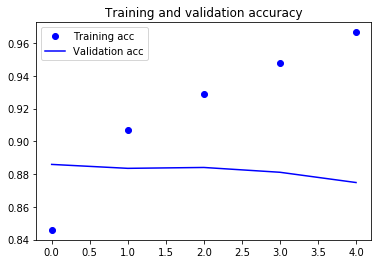

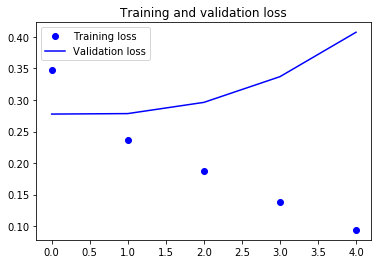

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
model_conv.evaluate(x_test, y_test)

25000/25000 [==============================] - 20s 788us/step


[0.4162595258152485, 0.87576]

## comment
For the first two epochs, the training accuracy and validation accuract are simiar, which means that the patterns or ruls network learns on the training generalize well to the unseen validation set. However, after two epochs, this network has overfitted the training data.

#  Using bidirectional RNNs

In [14]:
from keras import backend as K
K.clear_session()

In [15]:
model = Sequential()
model.add(Embedding(max_words, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          1280000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 1,543,425
Trainable params: 1,543,425
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 60000 samples, validate on 15000 samples
Epoch 1/10
60000/60000 [==============================] - 266s 4ms/step - loss: 0.3775 - acc: 0.8362 - val_loss: 0.3465 - val_acc: 0.8701
Epoch 2/10
60000/60000 [==============================] - 266s 4ms/step - loss: 0.2761 - acc: 0.8894 - val_loss: 0.3121 - val_acc: 0.8827
Epoch 3/10
60000/60000 [==============================] - 267s 4ms/step - loss: 0.2479 - acc: 0.9013 - val_loss: 0.3889 - val_acc: 0.8673
Epoch 4/10
60000/60000 [==============================] - 263s 4ms/step - loss: 0.2241 - acc: 0.9105 - val_loss: 0.2774 - val_acc: 0.8902
Epoch 5/10
60000/60000 [==============================] - 259s 4ms/step - loss: 0.2040 - acc: 0.9192 - val_loss: 0.2714 - val_acc: 0.8875
Epoch 6/10
60000/60000 [==============================] - 258s 4ms/step - loss: 0.1873 - acc: 0.9270 - val_loss: 0.2986 - val_acc: 0.8873
Epoch 7/10
60000/60000 [==============================] - 265s 4ms/step - loss: 0.1702 - acc: 0.9338 - val_loss: 0.2940 - 

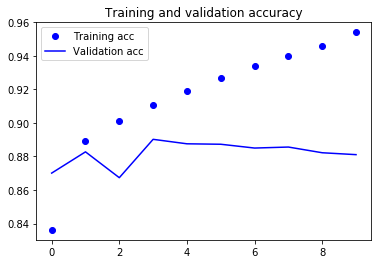

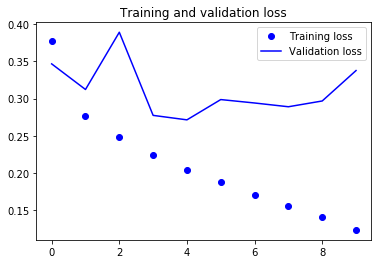

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 111s 4ms/step


[0.3383632601284981, 0.8822]